# Renewable Energy Systems (RES) project

This notebook includes the steps to optimize the capacity and dispatch of generators in the power system of one country.
Make sure that you understand every step in this notebook. For the project of the course Renewable Energy Systems (RES) you need to deliver a report including the sections described at the end of this notebook.

In [195]:
import pypsa
import pandas as pd
idx = pd.IndexSlice

We start by creating the network. In this example, the country is modelled as a single node, so the network will only include one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case Sweden (SWE), and add one node (electricity bus) to the network.

In [196]:
network = pypsa.Network()
hours_in_x=pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z',freq='H')

network.set_snapshots(hours_in_x)

network.add("Bus","electricity bus")

ct = "SWE"

The demand is represented by the historical electricity demand in 2015 with hourly resolution. 

The file with historical hourly electricity demand for every European country is available in the data folder.

The electricity demand time series were obtained from ENTSOE through the very convenient compilation carried out by the Open Power System Data (OPSD). https://data.open-power-system-data.org/time_series/

In the optimization, we will minimize the anualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [197]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [198]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv',sep=';',index_col=0) # in MWh
print(df_elec[ct].head())
df_elec = df_elec.set_index([[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]])

# Load cost data from pypsa-eur repository https://github.com/justmelson/pypsa-eur
costs = pd.read_csv("data/costs.csv",index_col=list(range(3))).sort_index()

#correct units to MW and EUR                                                                               
costs.loc[costs.unit.str.contains("/kW"),"value"]*=1e3
costs.loc[costs.unit.str.contains("USD"),"value"]*=0.7532

cost_year = 2030

costs = costs.loc[idx[:,cost_year,:],"value"].unstack(level=2).groupby(level="technology").sum(min_count=1)   

costs = costs.fillna({"CO2 intensity" : 0,
                          "FOM" : 0,
                          "VOM" : 0,
                          "discount rate" : 0.07,
                          "efficiency" : 1,
                          "fuel" : 0,
                          "investment" : 0,
                          "lifetime" : 25})

Nyears = 1

costs["discount rate"] = 0.07

costs["fixed"] = [(annuity(v["lifetime"],v["discount rate"])+v["FOM"]/100.)*v["investment"]*Nyears for i,v in costs.iterrows()]

# add load to the bus
network.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec[ct])

utc_time
2015-01-01T00:00:00Z    14845.0
2015-01-01T01:00:00Z    14554.0
2015-01-01T02:00:00Z    14267.0
2015-01-01T03:00:00Z    14224.0
2015-01-01T04:00:00Z    14370.0
Name: SWE, dtype: float64


We include solar PV, onshore and offshore wind generators. 

The capacity factors representing the availability of those generators for every European country can be downloaded from the following repositories (select optimal for PV and onshore for wind). 

https://zenodo.org/record/3253876#.XSiVOEdS8l0

https://zenodo.org/record/2613651#.XSiVOkdS8l0

We include also Open Cycle Gas Turbine (OCGT) generators

The cost assumed for the generators are the same as in the paper https://arxiv.org/pdf/1906.06936.pdf

We include a Nuclear reactor, as these are present in Sweden at the moment. 
Costs are taken from the report: Current and prospective costs of electricity
generation until 2050
http://hdl.handle.net/10419/80348


In [199]:
# add the different carriers, only gas and nuclear emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "offshorewind")
network.add("Carrier", "nuclear", co2_emissions=0.006)
network.add("Carrier", "hydro")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('data_extra/onshore_wind_1979-2017.csv',sep=';',index_col=0)
CF_wind=df_onshorewind[ct]
CF_wind=df_onshorewind[ct][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind=annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=15000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            #capital_cost = costs.at["onwind","fixed"],
            marginal_cost = 0,
            p_max_pu = CF_wind)

# add offshore wind generator
df_offshorewind = pd.read_csv('data_extra/offshore_wind_1979-2017.csv',sep=';',index_col=0)
CF_offwind=df_offshorewind[ct][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshorewind=annuity(25,0.07)*2506000*(1+0.033) # in €/MW
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            #capital_cost = costs.at["offwind","fixed"]+costs.at["offwind-dc-station","fixed"],
            marginal_cost = 0,
            p_max_pu = CF_offwind)


# add hydro generator
#df_hydro = pd.read_csv('data/inflow/hydro_inflow_se.csv',sep=',',index_col=0)
# skal inflow data laves om til kapacitetsfaktor? 
capital_cost_hydro=annuity(80,0.07)*2000000*(1+0.033) # in €/MW
network.add("Generator",
            "hydro",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="hydro",
            p_nom_max=(65168000/365)/24, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_hydro,
            #capital_cost = costs.at["hydro","fixed"],
            marginal_cost = 0)
            #p_max_pu = CF_hydro)

# add solar PV generator
df_solar = pd.read_csv('data_extra/pv_optimal.csv',sep=';',index_col=0)
CF_solar=df_solar[ct][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar=annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            #capital_cost = costs.at["solar","fixed"],
            marginal_cost = 0,
            p_max_pu = CF_solar)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT=annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost=21.6 # in €/MWh_th
efficiency=0.39
marginal_cost_OCGT=fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            #capital_cost = costs.at["OCGT","fixed"],
            marginal_cost = marginal_cost_OCGT)

# add NUCL (Nuclear reactor) generator
capital_cost_NUCL=annuity(50,0.07)*8000000*(1+0.033) # in €/MW
fuel_cost=4.7 # in €/MWh_th
efficiency=0.335
marginal_cost_NUCL=fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "NUCL",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=1000,
            capital_cost = capital_cost_NUCL,
            #capital_cost = costs.at["nuclear","fixed"],
            marginal_cost = marginal_cost_NUCL)



We solve the linear optimal power flow (lopf) using Gurobi as solver.

In this case, we are optimising the installed capacity and dispatch of every generator to minimize the total system cost.

In [200]:
network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x52567_copy
  Lower bound: 5318855730.464645
  Upper bound: 5318855730.464645
  Number of objectives: 1
  Number of constraints: 113881
  Number of variables: 52567
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 52567
  Number of nonzeros: 206221
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

The result ('ok', 'optimal') indicates that the optimizer has found an optimal solution. 

The total cost can be read from the network objective.
The first is the cost of the optimal solution in million euros


In [201]:
print(network.objective/1000000) #in 10^6 €
print(network.objective/network.loads_t.p.sum()) # €/MWh

5318.855730464646
load    39.130413
dtype: float64


The optimal capacity for every generator can be shown. (Capital G's for every technology)

In [204]:
network.generators.p_nom_opt

onshorewind     15000.000000
offshorewind        0.000000
hydro            7439.269406
solar            6288.461281
OCGT            15530.730594
NUCL                0.000000
Name: p_nom_opt, dtype: float64

So how will the different capacities be used? We can investigate this now. 
We can plot now the dispatch of every generator during the first week of the year and the electriticy demand.
We import the matplotlib package which is very useful to plot results

Range:
1-7 of January: 0-168
1-7 of June: 3624-3792

We can also plot the electricity mix.

In [206]:
l_range = 3624
u_range = 3782

Text(0.5, 1.0, '1-7 of January')

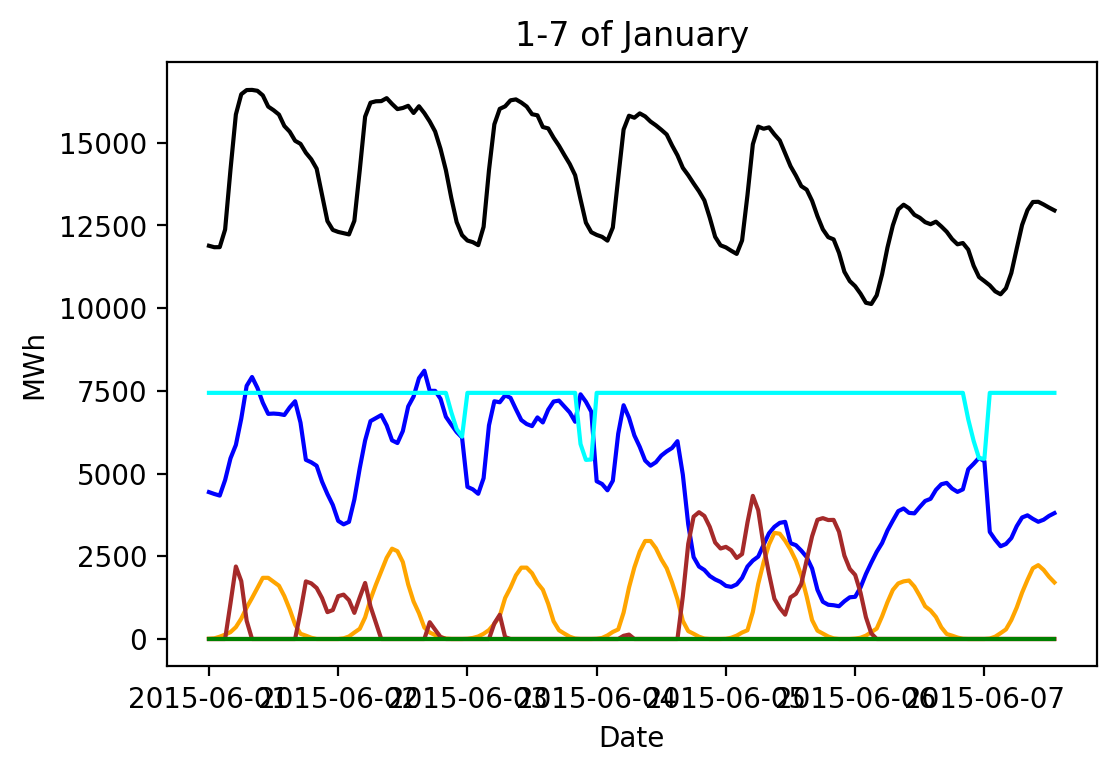

In [207]:
import matplotlib.pyplot as plt

plt.figure(dpi=200)
plt.plot(network.loads_t.p['load'][l_range:u_range], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][l_range:u_range], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['offshorewind'][l_range:u_range], color='red', label='offshore wind')
plt.plot(network.generators_t.p['solar'][l_range:u_range], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][l_range:u_range], color='brown', label='gas (OCGT)')
plt.plot(network.generators_t.p['NUCL'][l_range:u_range], color='green', label='nuclear (NUCL)')
plt.plot(network.generators_t.p['hydro'][l_range:u_range], color='cyan', label='hydro')
#plt.plot(network.stores_t.p['H2 Tank'][l_range:u_range], color='pink', label='Battery')
#plt.plot(network.stores.e_nom_opt['SWE battery'][l_range:u_range], color='pink', label='Battery')


plt.ylabel('MWh')
plt.xlabel('Date')
plt.title('1-7 of January')
#plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

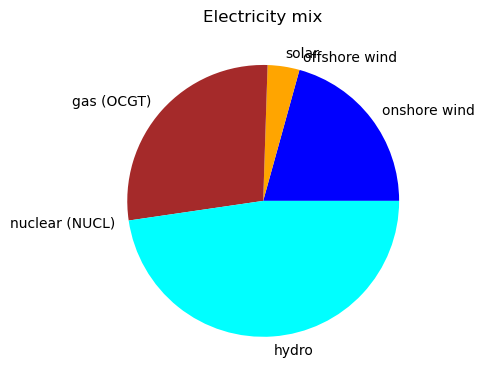

In [208]:
labels = ['onshore wind','offshore wind', 'solar', 'gas (OCGT)', 'nuclear (NUCL)','hydro' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum(),
         network.generators_t.p['NUCL'].sum(),
         network.generators_t.p['hydro'].sum()]

colors=['blue','red', 'orange', 'brown', 'green', 'cyan']
plt.figure(dpi=100)
plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)



In [209]:
#network.remove("GlobalConstraint", "co2_limit")
#network.buses_t.marginal_price.plot()

We can add a global CO2 constraint and solve again.

In [210]:
co2_lim = [250000, 500000, 1000000, 2000000,2910000, 4000000, 6000000] #tonCO2
generation_mix={}
#for i in range(5):
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_lim[4])

network.lopf(network.snapshots, solver_name='gurobi')

#network.remove("GlobalConstraint", "co2_limit")
    #generation_mix[i]= network.generators.p_nom_opt

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x52567_copy
  Lower bound: 6292581549.969848
  Upper bound: 6292581549.969848
  Number of objectives: 1
  Number of constraints: 113882
  Number of variables: 52567
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 52567
  Number of nonzeros: 223741
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [211]:
network.generators.p_nom_opt
#generation_mix

onshorewind     15000.000000
offshorewind     2483.357995
hydro            7439.269406
solar            9276.076596
OCGT            12552.500230
NUCL             2545.576146
Name: p_nom_opt, dtype: float64

In [213]:
print(network.global_constraints.constant) #CO2 limit (constant in the constraint)

print(network.global_constraints.mu) #CO2 price (Lagrance multiplier in the constraint)

co2_limit    2910000.0
Name: constant, dtype: float64
co2_limit    430.973427
Name: mu, dtype: float64


Text(0.5, 1.0, '1-7 of January')

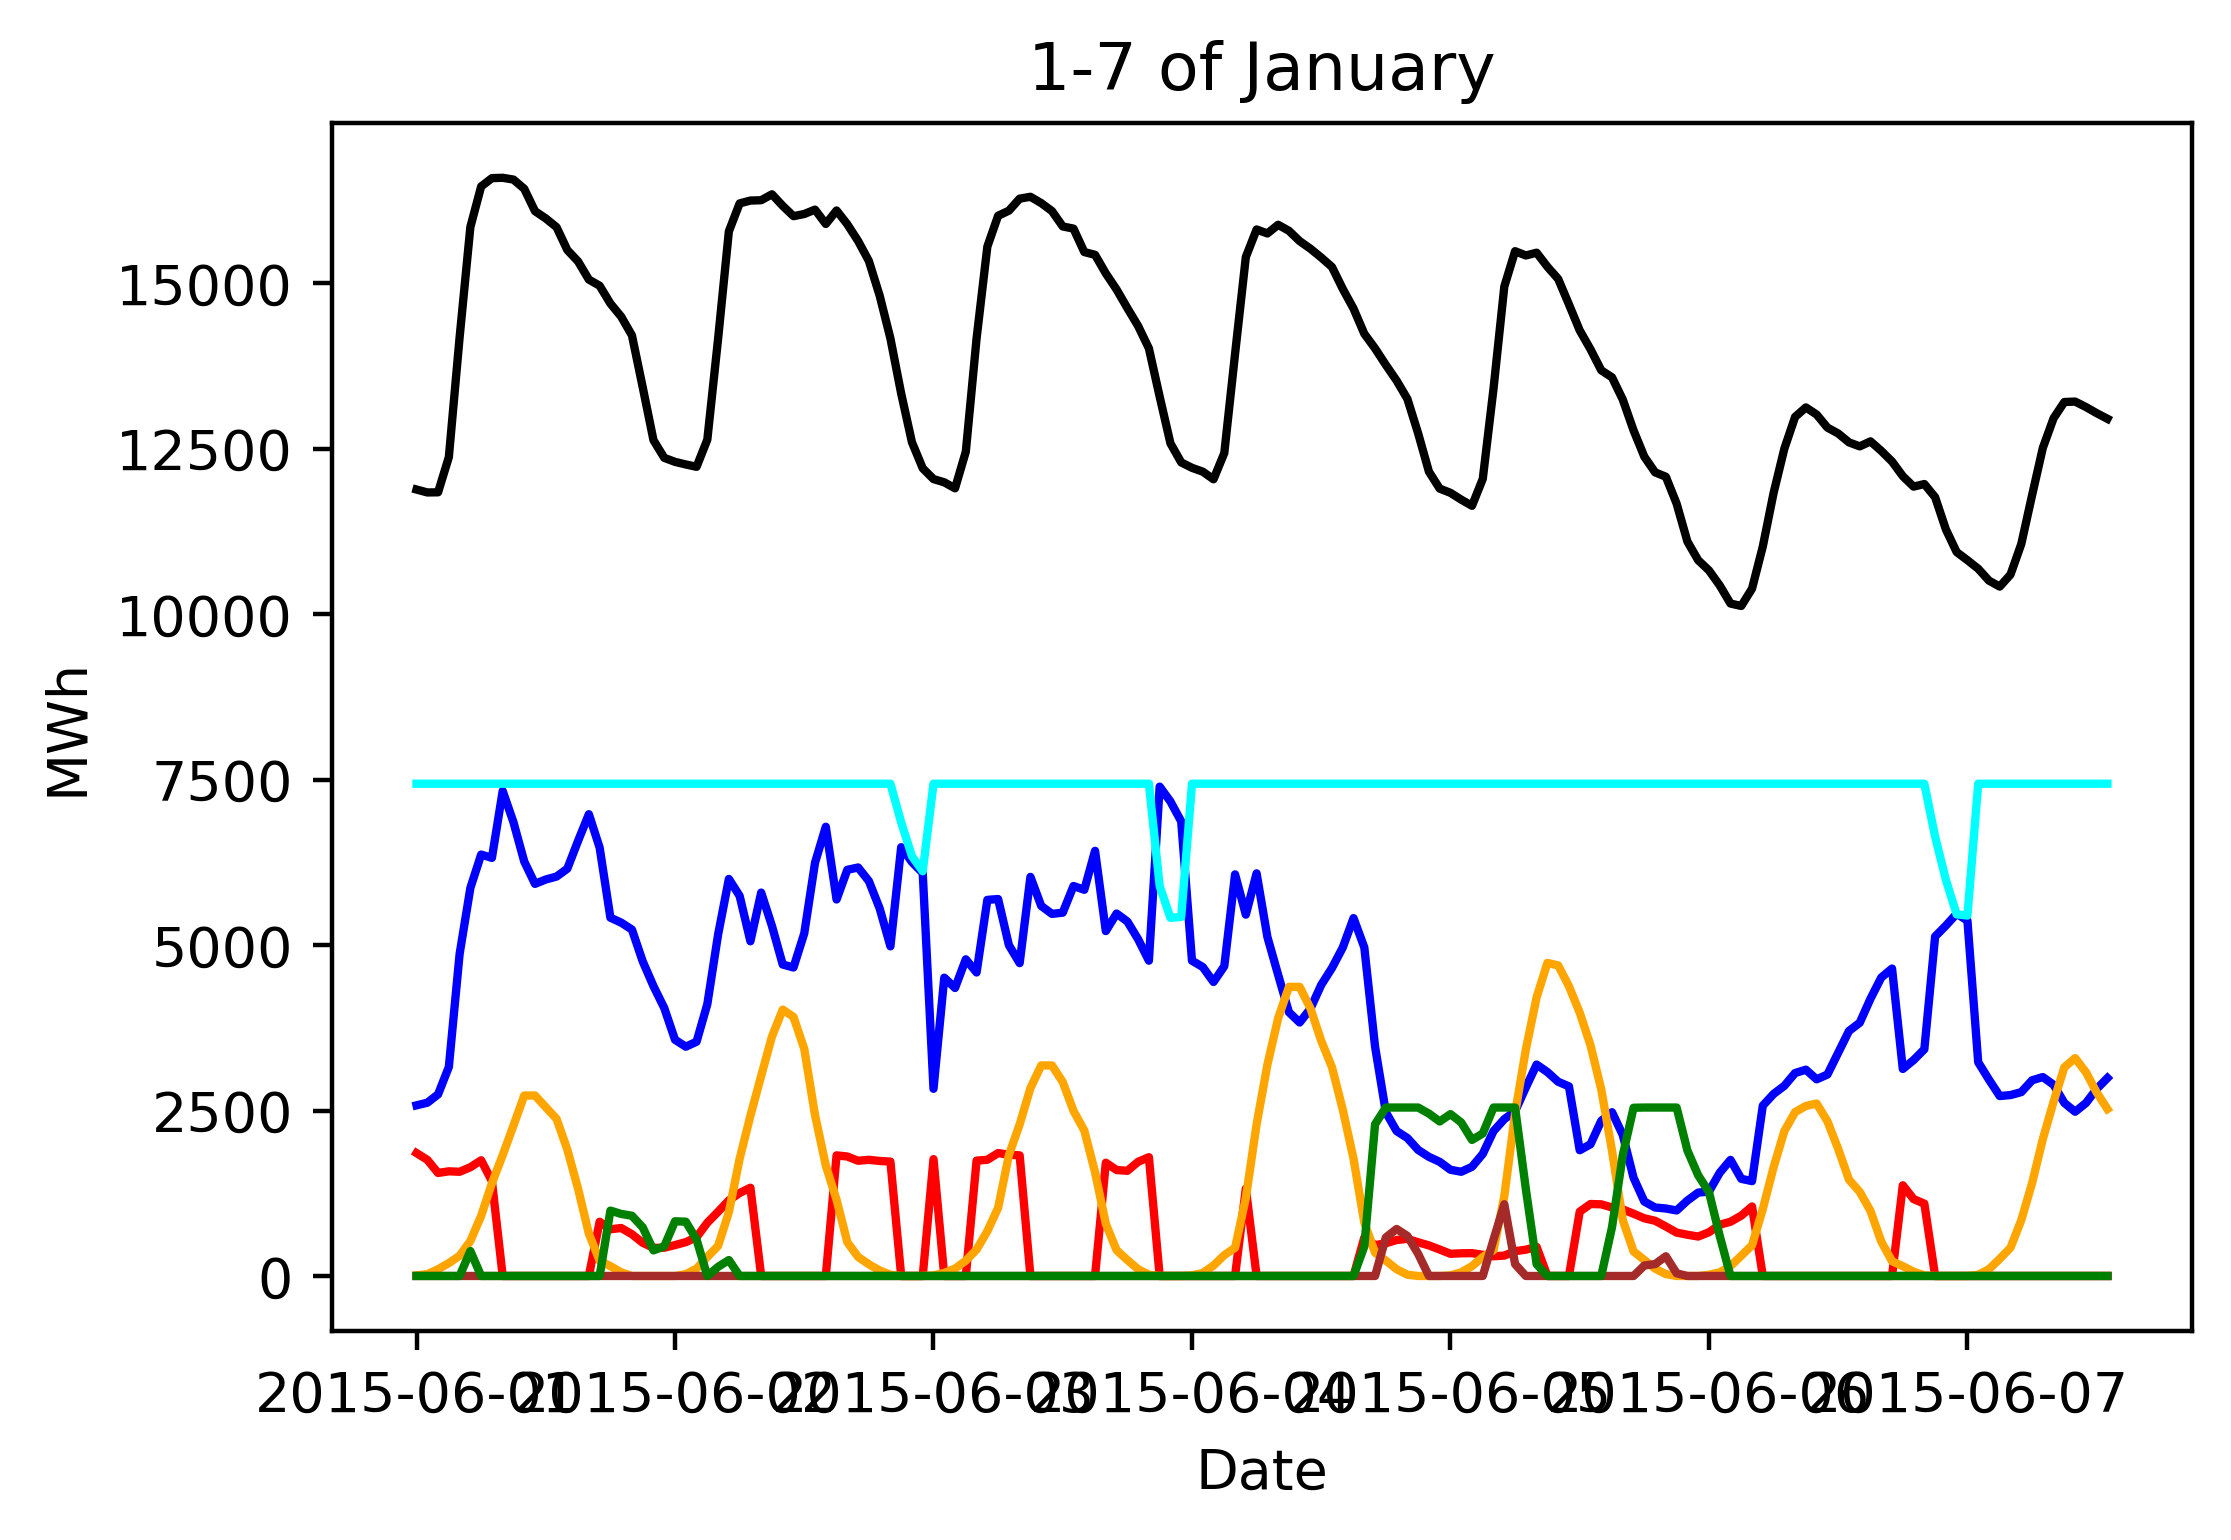

In [214]:
import matplotlib.pyplot as plt

plt.figure(dpi=400)
plt.plot(network.loads_t.p['load'][l_range:u_range], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][l_range:u_range], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['offshorewind'][l_range:u_range], color='red', label='offshore wind')
plt.plot(network.generators_t.p['hydro'][l_range:u_range], color='cyan', label='hydro')
plt.plot(network.generators_t.p['solar'][l_range:u_range], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][l_range:u_range], color='brown', label='gas (OCGT)')
plt.plot(network.generators_t.p['NUCL'][l_range:u_range], color='green', label='nuclear (NUCL)')
plt.ylabel('MWh')
plt.xlabel('Date')
plt.title('1-7 of January')
#plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

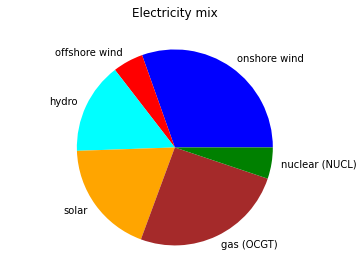

In [215]:
labels = ['onshore wind','offshore wind','hydro', 'solar', 'gas (OCGT)', 'nuclear (NUCL)' ]
sizes = [network.generators.p_nom_opt['onshorewind'].sum(),
         network.generators.p_nom_opt['offshorewind'].sum(),
         network.generators.p_nom_opt['hydro'].sum(),
         network.generators.p_nom_opt['solar'].sum(),
         network.generators.p_nom_opt['OCGT'].sum(),
         network.generators.p_nom_opt['NUCL'].sum()]

colors = ['blue','red','cyan', 'orange', 'brown', 'green']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

Include battery storage

In [20]:
"""network.remove("Bus",ct + " battery")
network.remove("Store",ct + " battery")
network.remove("Link",ct + " battery charge")
network.remove("Link",ct + " battery discharge")

network.remove("Carrier","H2")
network.remove("Bus","H2")
network.remove("Store","H2 Tank")
network.remove("Link","H2 Electrolysis")
network.remove("Link","H2 Fuel Cell")


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-20-e5643aa20f3d>, line 10)

In [216]:
# Battery store

network.add("Bus",ct + " battery")

capital_cost_bat=annuity(15,0.07)*192000*(1+0.033) # in €/MW
network.add("Store",ct + " battery",
                bus = ct + " battery",
                e_nom_extendable = True,
                e_cyclic=True,
                capital_cost=capital_cost_bat)

capital_cost_inv=annuity(20,0.07)*338080*(1+0.033) # in €/MW
network.add("Link",ct + " battery charge",
                bus0 = "electricity bus",
                bus1 = ct + " battery",
                efficiency = costs.at['battery inverter','efficiency']**0.5,
                p_nom_extendable = True,
                capital_cost=capital_cost_inv)

network.add("Link",ct + " battery discharge",
                bus0 = ct + " battery",
                bus1 = "electricity bus",
                p_nom_extendable = True,
                efficiency = costs.at['battery inverter','efficiency']**0.5)

#Create a new carrier
network.add("Carrier",
      "H2")

#Create a new bus
network.add("Bus",
      "H2",
      carrier = "H2")

#Connect the store to the bus
network.add("Store",
      "H2 Tank",
      bus = "H2",
      e_nom_extendable = True,
      e_cyclic = True,
      #capital_cost=costs.at["hydrogen storage","fixed"])
      capital_cost = annuity(25, 0.07)*57000*(1+0.011))


#Add the link "H2 Electrolysis" that transport energy from the electricity bus (bus0) to the H2 bus (bus1)
#with 80% efficiency
network.add("Link",
      "H2 Electrolysis", 
      bus0 = "electricity bus",
      bus1 = "H2",     
      p_nom_extendable = True,
      efficiency=costs.at["electrolysis","efficiency"],
      #capital_cost=costs.at["electrolysis","fixed"])
      #efficiency = 0.8,
      capital_cost = annuity(18, 0.07)*600000*(1+0.05)) # 600000

#Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
      "H2 Fuel Cell", 
      bus0 = "H2",
      bus1 = "electricity bus",     
      p_nom_extendable = True,
      efficiency=costs.at["fuel cell","efficiency"],
      #capital_cost=costs.at["fuel cell","fixed"]*costs.at["fuel cell","efficiency"])
      capital_cost = annuity(10, 0.07)*1300000*(1+0.05)) # 1300000


New optimization with battery storage and CO2 constraint

In [217]:
network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x122653_copy
  Lower bound: 6250082701.952018
  Upper bound: 6250082701.952018
  Number of objectives: 1
  Number of constraints: 254042
  Number of variables: 122653
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 122653
  Number of nonzeros: 521581
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminati

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [218]:
print(network.stores.e_nom_opt)

SWE battery    4564.2098
H2 Tank           0.0000
Name: e_nom_opt, dtype: float64


In [219]:
network.links

attribute,bus0,bus1,type,efficiency,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,p_nom_opt
SWE battery charge,electricity bus,SWE battery,,0.948683,0.0,True,0.0,inf,0.0,0.0,1.0,32965.468226,0.0,0.0,1.0,687.299937
SWE battery discharge,SWE battery,electricity bus,,0.948683,0.0,True,0.0,inf,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,3999.994461
H2 Electrolysis,electricity bus,H2,,0.800000,0.0,True,0.0,inf,0.0,0.0,1.0,62629.939045,0.0,0.0,1.0,0.000000
H2 Fuel Cell,H2,electricity bus,,0.580000,0.0,True,0.0,inf,0.0,0.0,1.0,194345.291223,0.0,0.0,1.0,0.000000


In [172]:
print(network.global_constraints.constant) #CO2 limit (constant in the constraint)

print(network.global_constraints.mu) #CO2 price (Lagrance multiplier in the constraint)

co2_limit    2910000.0
Name: constant, dtype: float64
co2_limit    2053.81168
Name: mu, dtype: float64


Text(0.5, 1.0, '1-7 of June')

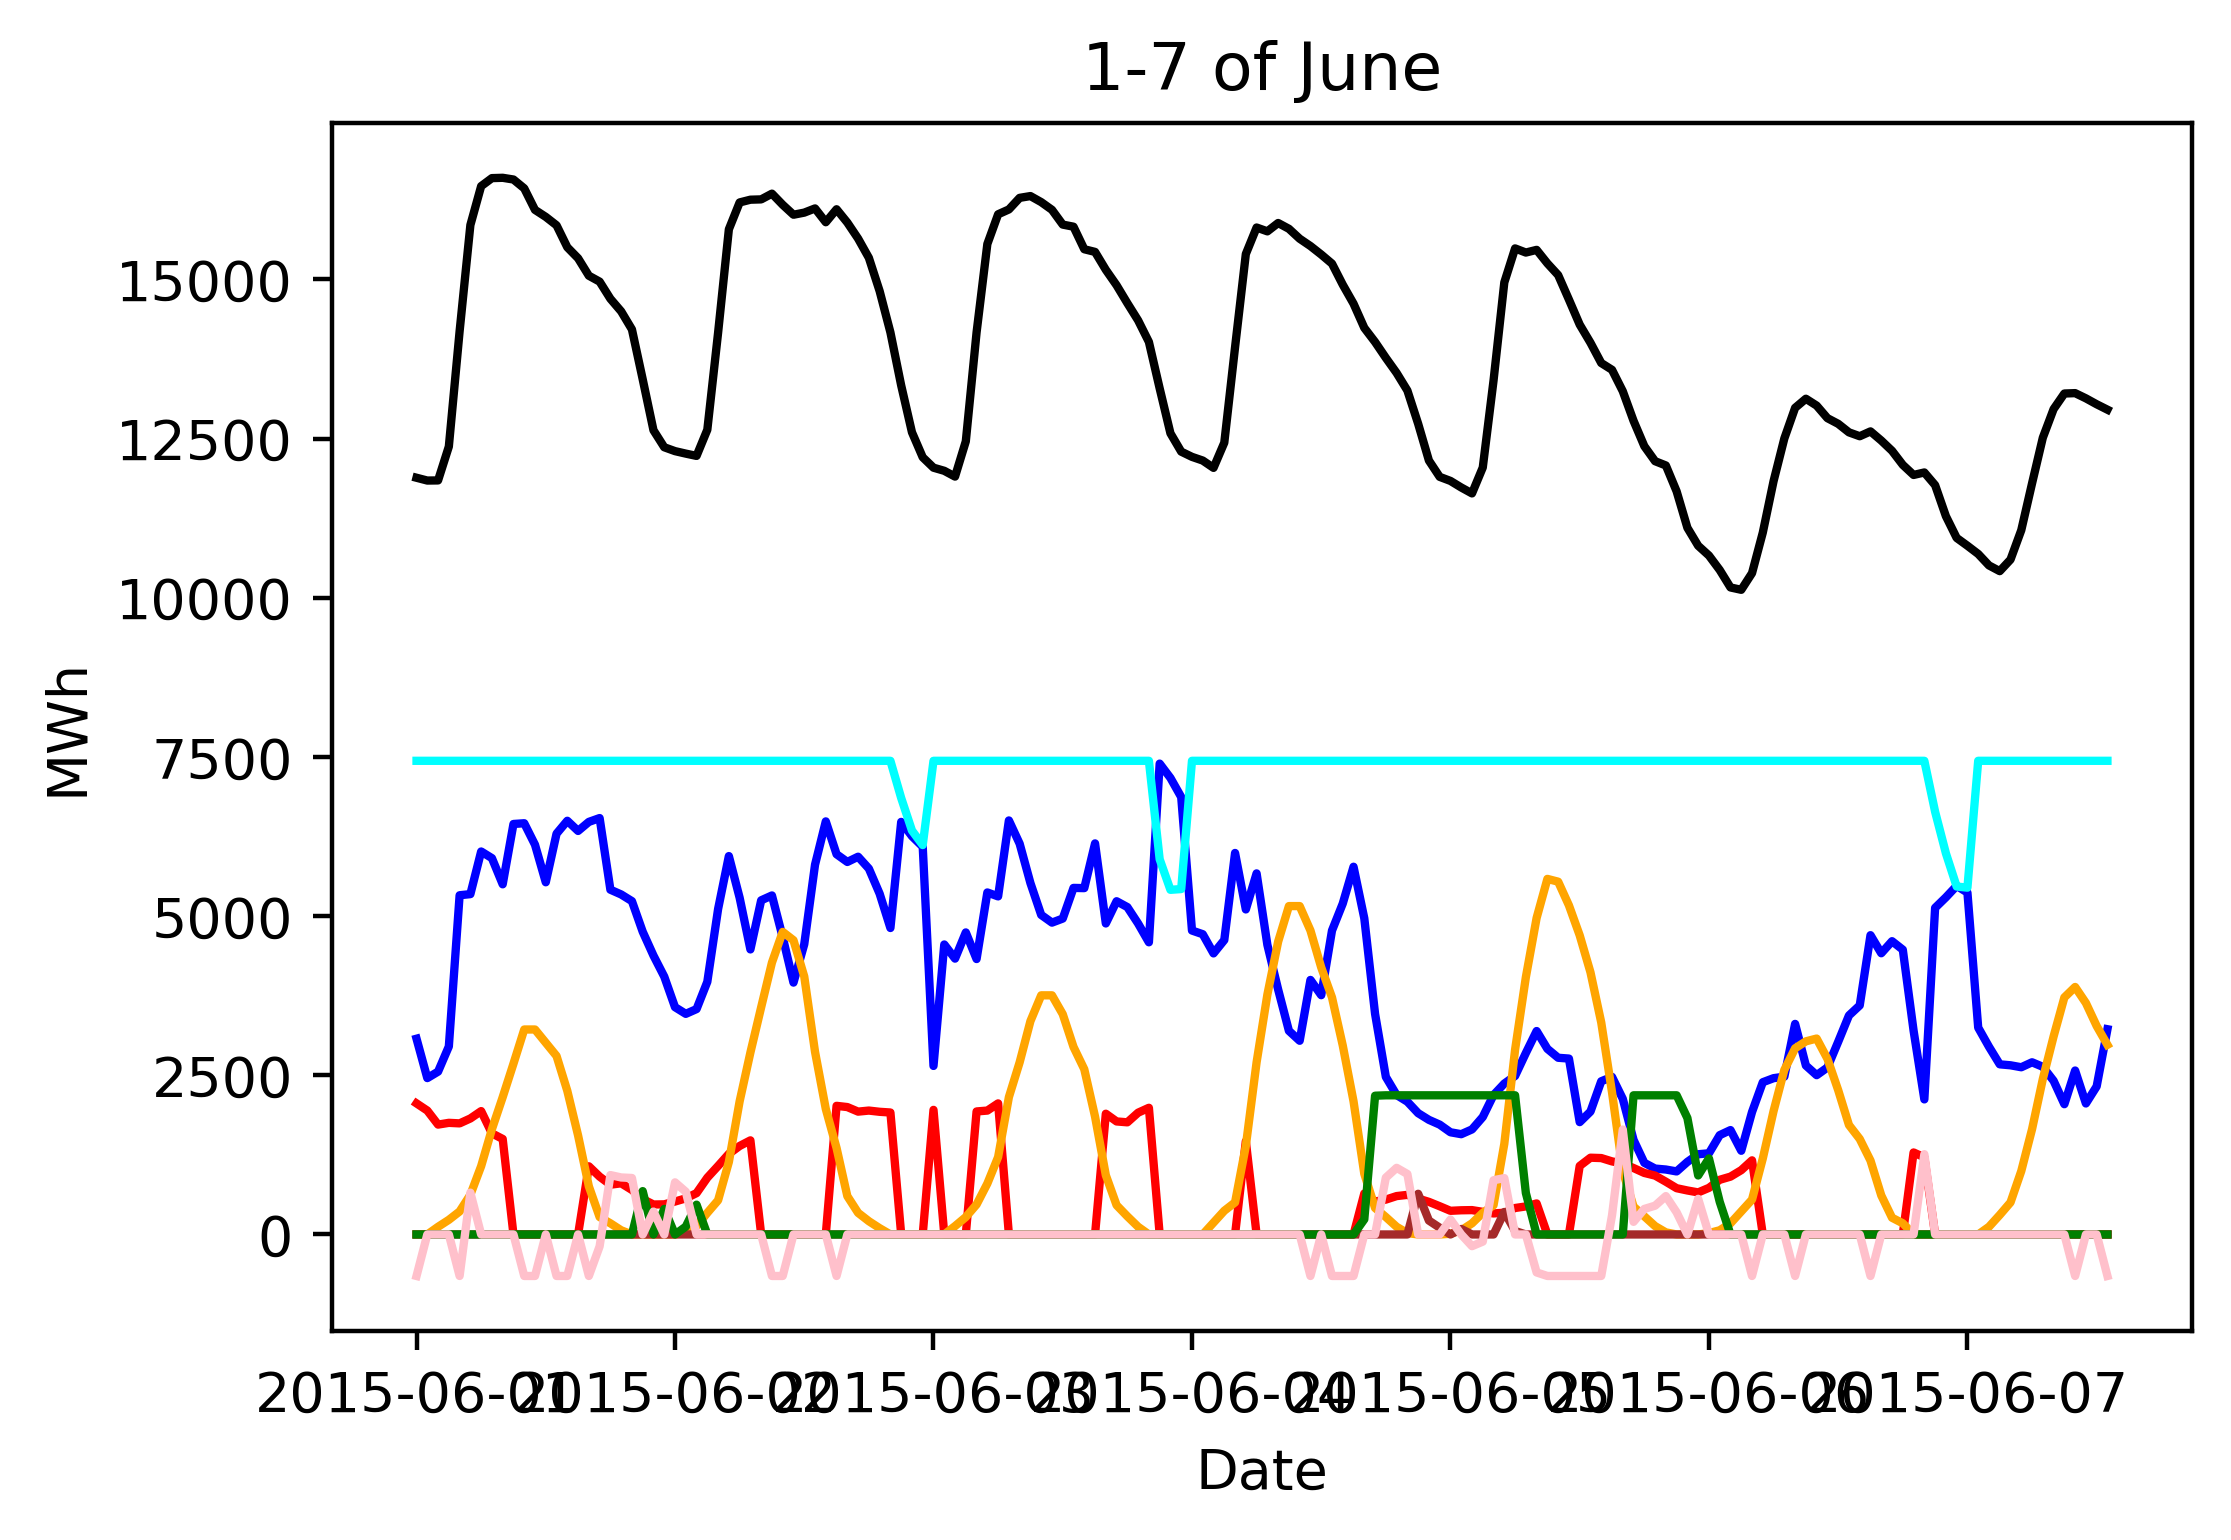

In [225]:
import matplotlib.pyplot as plt

plt.figure(dpi=400)
plt.plot(network.loads_t.p['load'][l_range:u_range], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][l_range:u_range], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['offshorewind'][l_range:u_range], color='red', label='offshore wind')
plt.plot(network.generators_t.p['hydro'][l_range:u_range], color='cyan', label='hydro')
plt.plot(network.generators_t.p['solar'][l_range:u_range], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][l_range:u_range], color='brown', label='gas (OCGT)')
plt.plot(network.generators_t.p['NUCL'][l_range:u_range], color='green', label='nuclear (NUCL)')
plt.plot(network.stores_t.p['SWE battery'][l_range:u_range], color='pink', label='Battery store')
#plt.plot(network.links_t.p['H2 Fuel Cell'][l_range:u_range], color='yellow', label='H2')
plt.ylabel('MWh')
plt.xlabel('Date')
plt.title('1-7 of June')
#plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

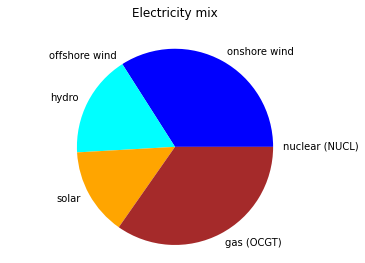

In [25]:
labels = ['onshore wind','offshore wind','hydro', 'solar', 'gas (OCGT)', 'nuclear (NUCL)' ]
sizes = [network.generators.p_nom_opt['onshorewind'].sum(),
         network.generators.p_nom_opt['offshorewind'].sum(),
         network.generators.p_nom_opt['hydro'].sum(),
         network.generators.p_nom_opt['solar'].sum(),
         network.generators.p_nom_opt['OCGT'].sum(),
         network.generators.p_nom_opt['NUCL'].sum()]

colors = ['blue','red','cyan', 'orange', 'brown', 'green']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

Connect neighbor countries


In [26]:
#network.remove("Load","loadNOR")


In [27]:
#generator capacities
#generator_p_nom = {"DNK" : {"Coal" : 370,
 #                           "Wind" : 1842,
  #                       "Biofuel" : 370,
   #                         "OCGT" : 211
    #                          },
     #              "NOR" : {"Hydro" : 14350,
      #                       "Wind" : 631
       #                      }}

#transmission capacities in MW (not necessarily realistic)
#transmission = {"SWE" : {"DNK" : 2440,
#                        "NOR" : 2500},
#                "NOR" : {"DNK" : 1740}}

countries = ["DNK","NOR"]
#network.remove("Bus","DNK")
#network.remove("Bus","NOR")

for country in countries:
    network.add("Bus",country)
    # add load to the bus
    network.add("Load",
                "load"+country, 
                bus=country, 
                p_set=df_elec[country])

In [28]:
# Links between countries
capital_cost_HVDCsub = annuity(40,0.07)*2000*(1+0.033) # in €/MW
capital_cost_HVAC = annuity(40,0.07)*400*(1+0.033) # in €/MW


network.add("Link",
           "SWE - NOR link",
           bus0="electricity bus",
           bus1="NOR",
           #p_nom=2500,
           p_nom_extendable=True, # capacity is optimised
           p_min_pu=-1,
           length=600, # length (in km) between country a and country b
           capital_cost=capital_cost_HVAC*600) # capital cost * length )

network.add("Link",
           "SWE - DNK link",
           bus0="electricity bus",
           bus1="DNK",
           #p_nom=2440,
           p_nom_extendable=True,
           p_min_pu=-1,
           length=200, # length (in km) between country a and country b
           capital_cost=capital_cost_HVDCsub*600) # capital cost * length ))

network.add("Link",
           "DNK - NOR link",
           bus0="DNK",
           bus1="NOR",
           #p_nom=1740,
           p_nom_extendable=True,
           p_min_pu=-1,
           length=240, # length (in km) between country a and country b
           capital_cost=capital_cost_HVDCsub*600) # capital cost * length )



In [29]:
#for tech in generator_p_nom[country]:

generator_p_nom = {"DNK" : 2793,
                   "NOR" : 14981}

for country in countries:
    network.add("Generator",country+"gen",
                bus=country,
                p_nom=generator_p_nom[country],
                marginal_cost=0)

In [30]:
#network.remove("Link","DNK - NOR link")

In [31]:
network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x166456_copy
  Lower bound: 6732265247.812187
  Upper bound: 6732265247.812187
  Number of objectives: 1
  Number of constraints: 324121
  Number of variables: 166456
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 166456
  Number of nonzeros: 679261
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminati

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [32]:
network.links

attribute,bus0,bus1,type,efficiency,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,p_nom_opt
SWE battery charge,electricity bus,SWE battery,,0.948683,0.0,True,0.0,inf,0.0,0.0,1.0,32965.468226,0.0,0.0,1.0,130.196615
SWE battery discharge,SWE battery,electricity bus,,0.948683,0.0,True,0.0,inf,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,988.122835
H2 Electrolysis,electricity bus,H2,,0.800000,0.0,True,0.0,inf,0.0,0.0,1.0,62629.939045,0.0,0.0,1.0,0.000000
H2 Fuel Cell,H2,electricity bus,,0.580000,0.0,True,0.0,inf,0.0,0.0,1.0,194345.291223,0.0,0.0,1.0,0.000000
SWE - NOR link,electricity bus,NOR,,1.000000,0.0,True,0.0,inf,0.0,-1.0,1.0,18596.265710,0.0,600.0,1.0,7342.415000
SWE - DNK link,electricity bus,DNK,,1.000000,0.0,True,0.0,inf,0.0,-1.0,1.0,92981.328548,0.0,200.0,1.0,2710.365000
DNK - NOR link,DNK,NOR,,1.000000,0.0,True,0.0,inf,0.0,-1.0,1.0,92981.328548,0.0,240.0,1.0,206.585000


<Figure size 432x288 with 0 Axes>

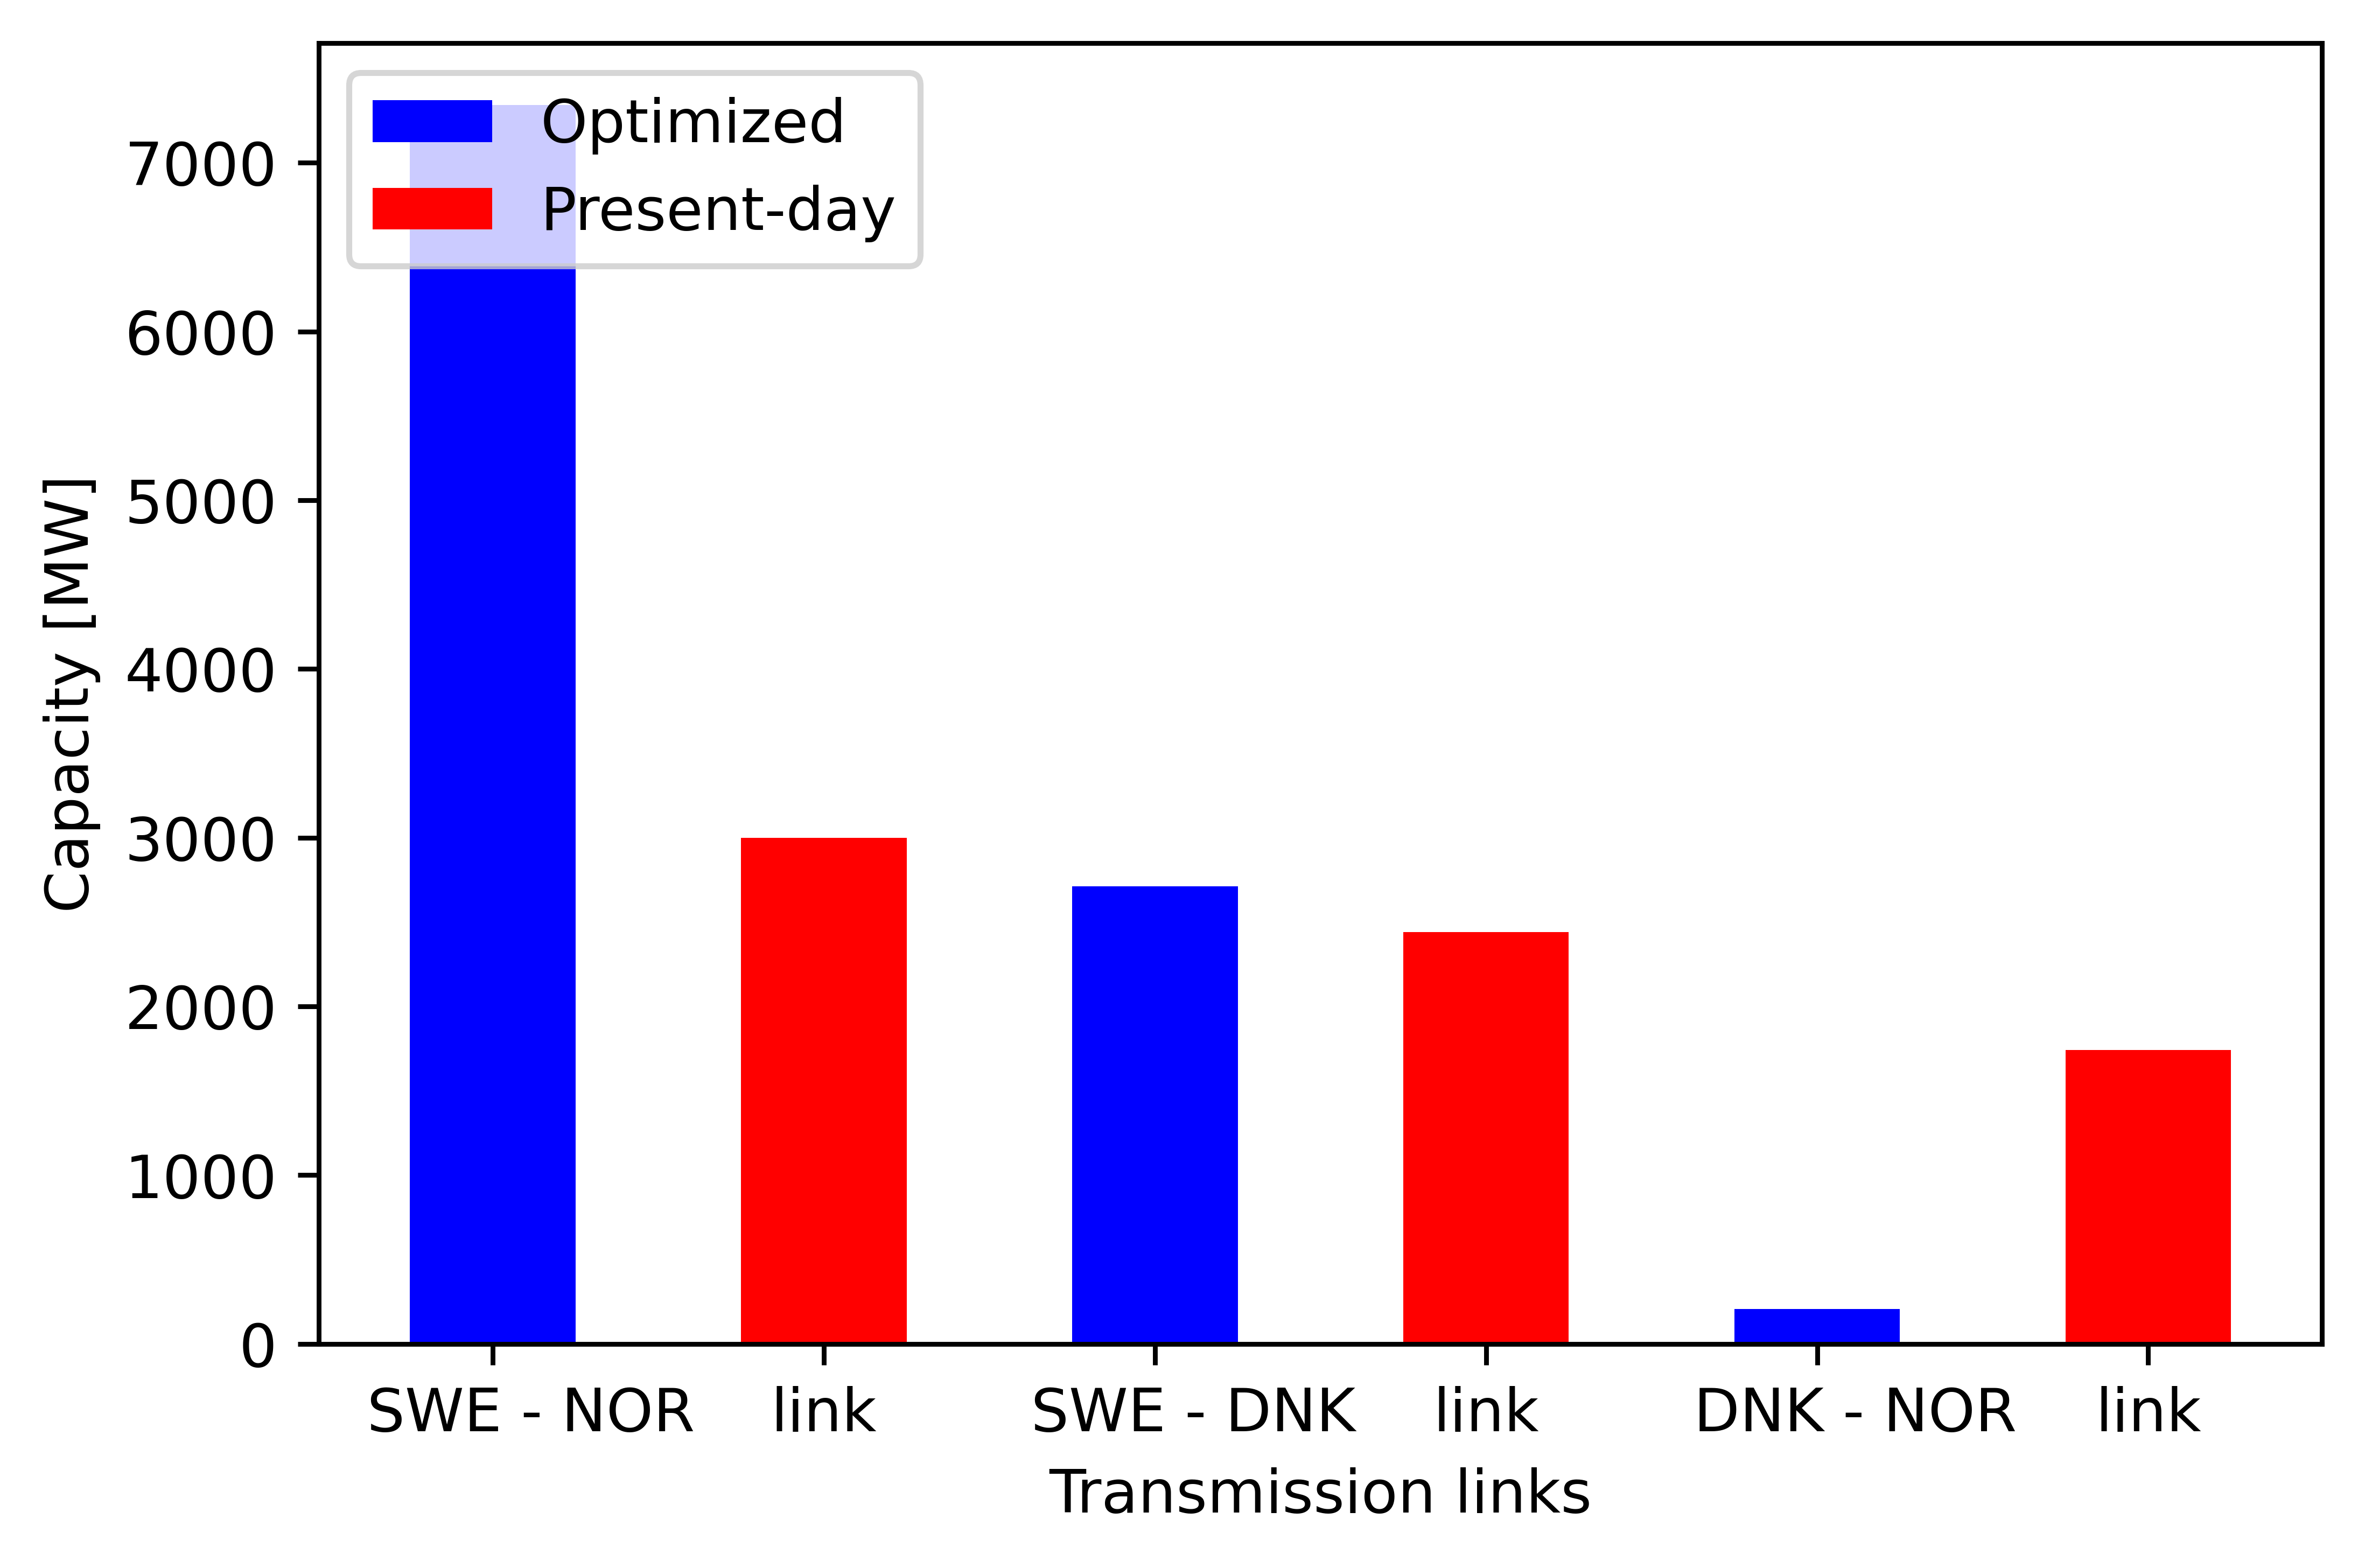

In [33]:
r = [0,1,2,3,4,5]
links = ["    SWE - NOR","link","    SWE - DNK","link","    DNK - NOR","link"]

barWidth = 0.5
plt.figure(1)
plt.figure(dpi=800)
plt.bar(0, network.links.p_nom_opt["SWE - NOR link"], color='blue', width=barWidth, label = "Optimized")
plt.bar(2, network.links.p_nom_opt["SWE - DNK link"], color='blue', width=barWidth)# label = "Optimized")
plt.bar(4, network.links.p_nom_opt["DNK - NOR link"], color='blue', width=barWidth)# label = "Optimized")
plt.bar(1, 3000, color='red', width=barWidth, label = "Present-day")
plt.bar(3, 2440, color='red', width=barWidth) #label = "Present-day")
plt.bar(5, 1740, color='red', width=barWidth)# label = "Present-day")


plt.xticks(r, links)
plt.xlabel("Transmission links")
plt.ylabel('Capacity [MW]')
plt.legend(loc='upper left')

Couple with a heat sector

In [82]:
# load heat demand data
df_heat = pd.read_csv('data/heat_demand.csv',sep=';',index_col=0) # in MWh
print(df_heat[ct].head())
df_heat = df_heat.set_index([[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]])

# add load to the bus
network.remove("Load",
            "heatload")
network.add("Load",
            "heatload", 
            bus="heat bus", 
            p_set=df_heat[ct])

utc_time
2015-01-01T00:00:00Z    13570.110651
2015-01-01T01:00:00Z    13431.844610
2015-01-01T02:00:00Z    13491.804101
2015-01-01T03:00:00Z    13509.215346
2015-01-01T04:00:00Z    13426.265672
Name: SWE, dtype: float64


In [115]:
network.remove("GlobalConstraint", "co2_limit")

In [116]:
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=2910000)

In [137]:
network.remove("Bus","heat bus")
network.remove("Link","heat pump")
#network.remove("Carrier","biomass")
#network.remove("Generator","biomass generator")
network.remove("Generator","boiler")

In [138]:
network.add("Bus","heat bus",carrier="heat")
network.add("Link",
            "heat pump",
            bus0="electricity bus",
            bus1="heat bus",
            p_nom_extendable = True,
            capital_cost = annuity(20,0.04)*933000*(1+0.035),
            efficiency=3)

#network.add("Carrier","biomass",co2_emissions=0.)
"""
network.add("Generator","biomass generator",
            bus="heat bus",
            p_nom_extendable=True,
            marginal_cost=100,
            capital_cost = annuity(30,0.07)*2209000*(1+0.035),
            efficiency=0.3,
            carrier="biomass")
"""
# Boiler for heat generation
fuel_cost=21.6 # in €/MWh_th
network.add("Generator","boiler",
            bus="heat bus",
            p_nom_extendable=True,
            efficiency=0.9,
            capital_cost = annuity(20,0.04)*175000*(1+0.035),
            marginal_cost=21.6/0.9, # in €/MWh_el,
            carrier="gas")

In [139]:
network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x183978_copy
  Lower bound: 12796639933.323444
  Upper bound: 12796639933.323444
  Number of objectives: 1
  Number of constraints: 367922
  Number of variables: 183978
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 183978
  Number of nonzeros: 784381
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

Text(0.5, 1.0, '1-7 of January')

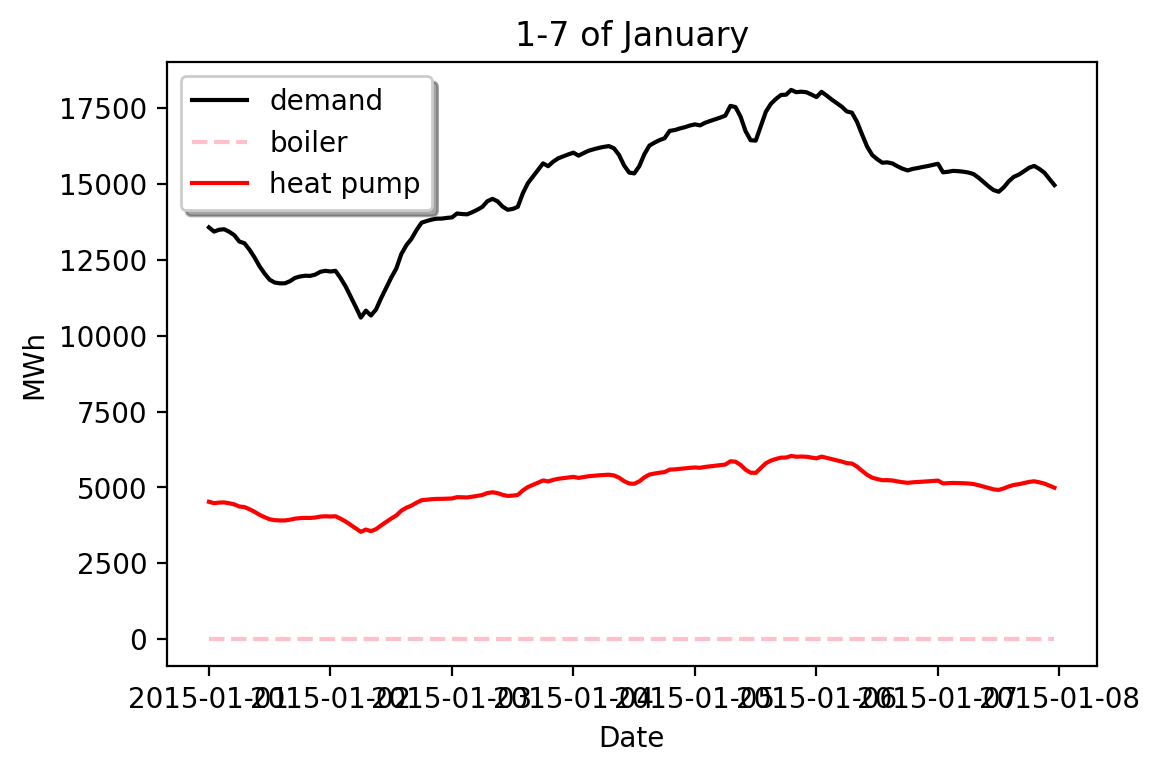

In [140]:
plt.figure(dpi=200)
plt.plot(network.loads_t.p['heatload'][l_range:u_range], color='black', label='demand')
plt.plot(network.generators_t.p['boiler'][l_range:u_range], color='pink', label='boiler',linestyle='dashed')
plt.plot(network.links_t.p0['heat pump'][l_range:u_range], color='red', label='heat pump')
#plt.plot(network.carriers_t.p['gas'][l_range:u_range], color='green', label='gas')

plt.legend(fancybox=True, shadow=True, loc='best')

plt.ylabel('MWh')
plt.xlabel('Date')
plt.title('1-7 of January')

In [143]:
network.remove("Generator","NUCL")

In [144]:
network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x175217_copy
  Lower bound: 13960179716.784634
  Upper bound: 13960179716.784634
  Number of objectives: 1
  Number of constraints: 350402
  Number of variables: 175217
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 175217
  Number of nonzeros: 740581
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

Text(0.5, 1.0, '1-7 of June')

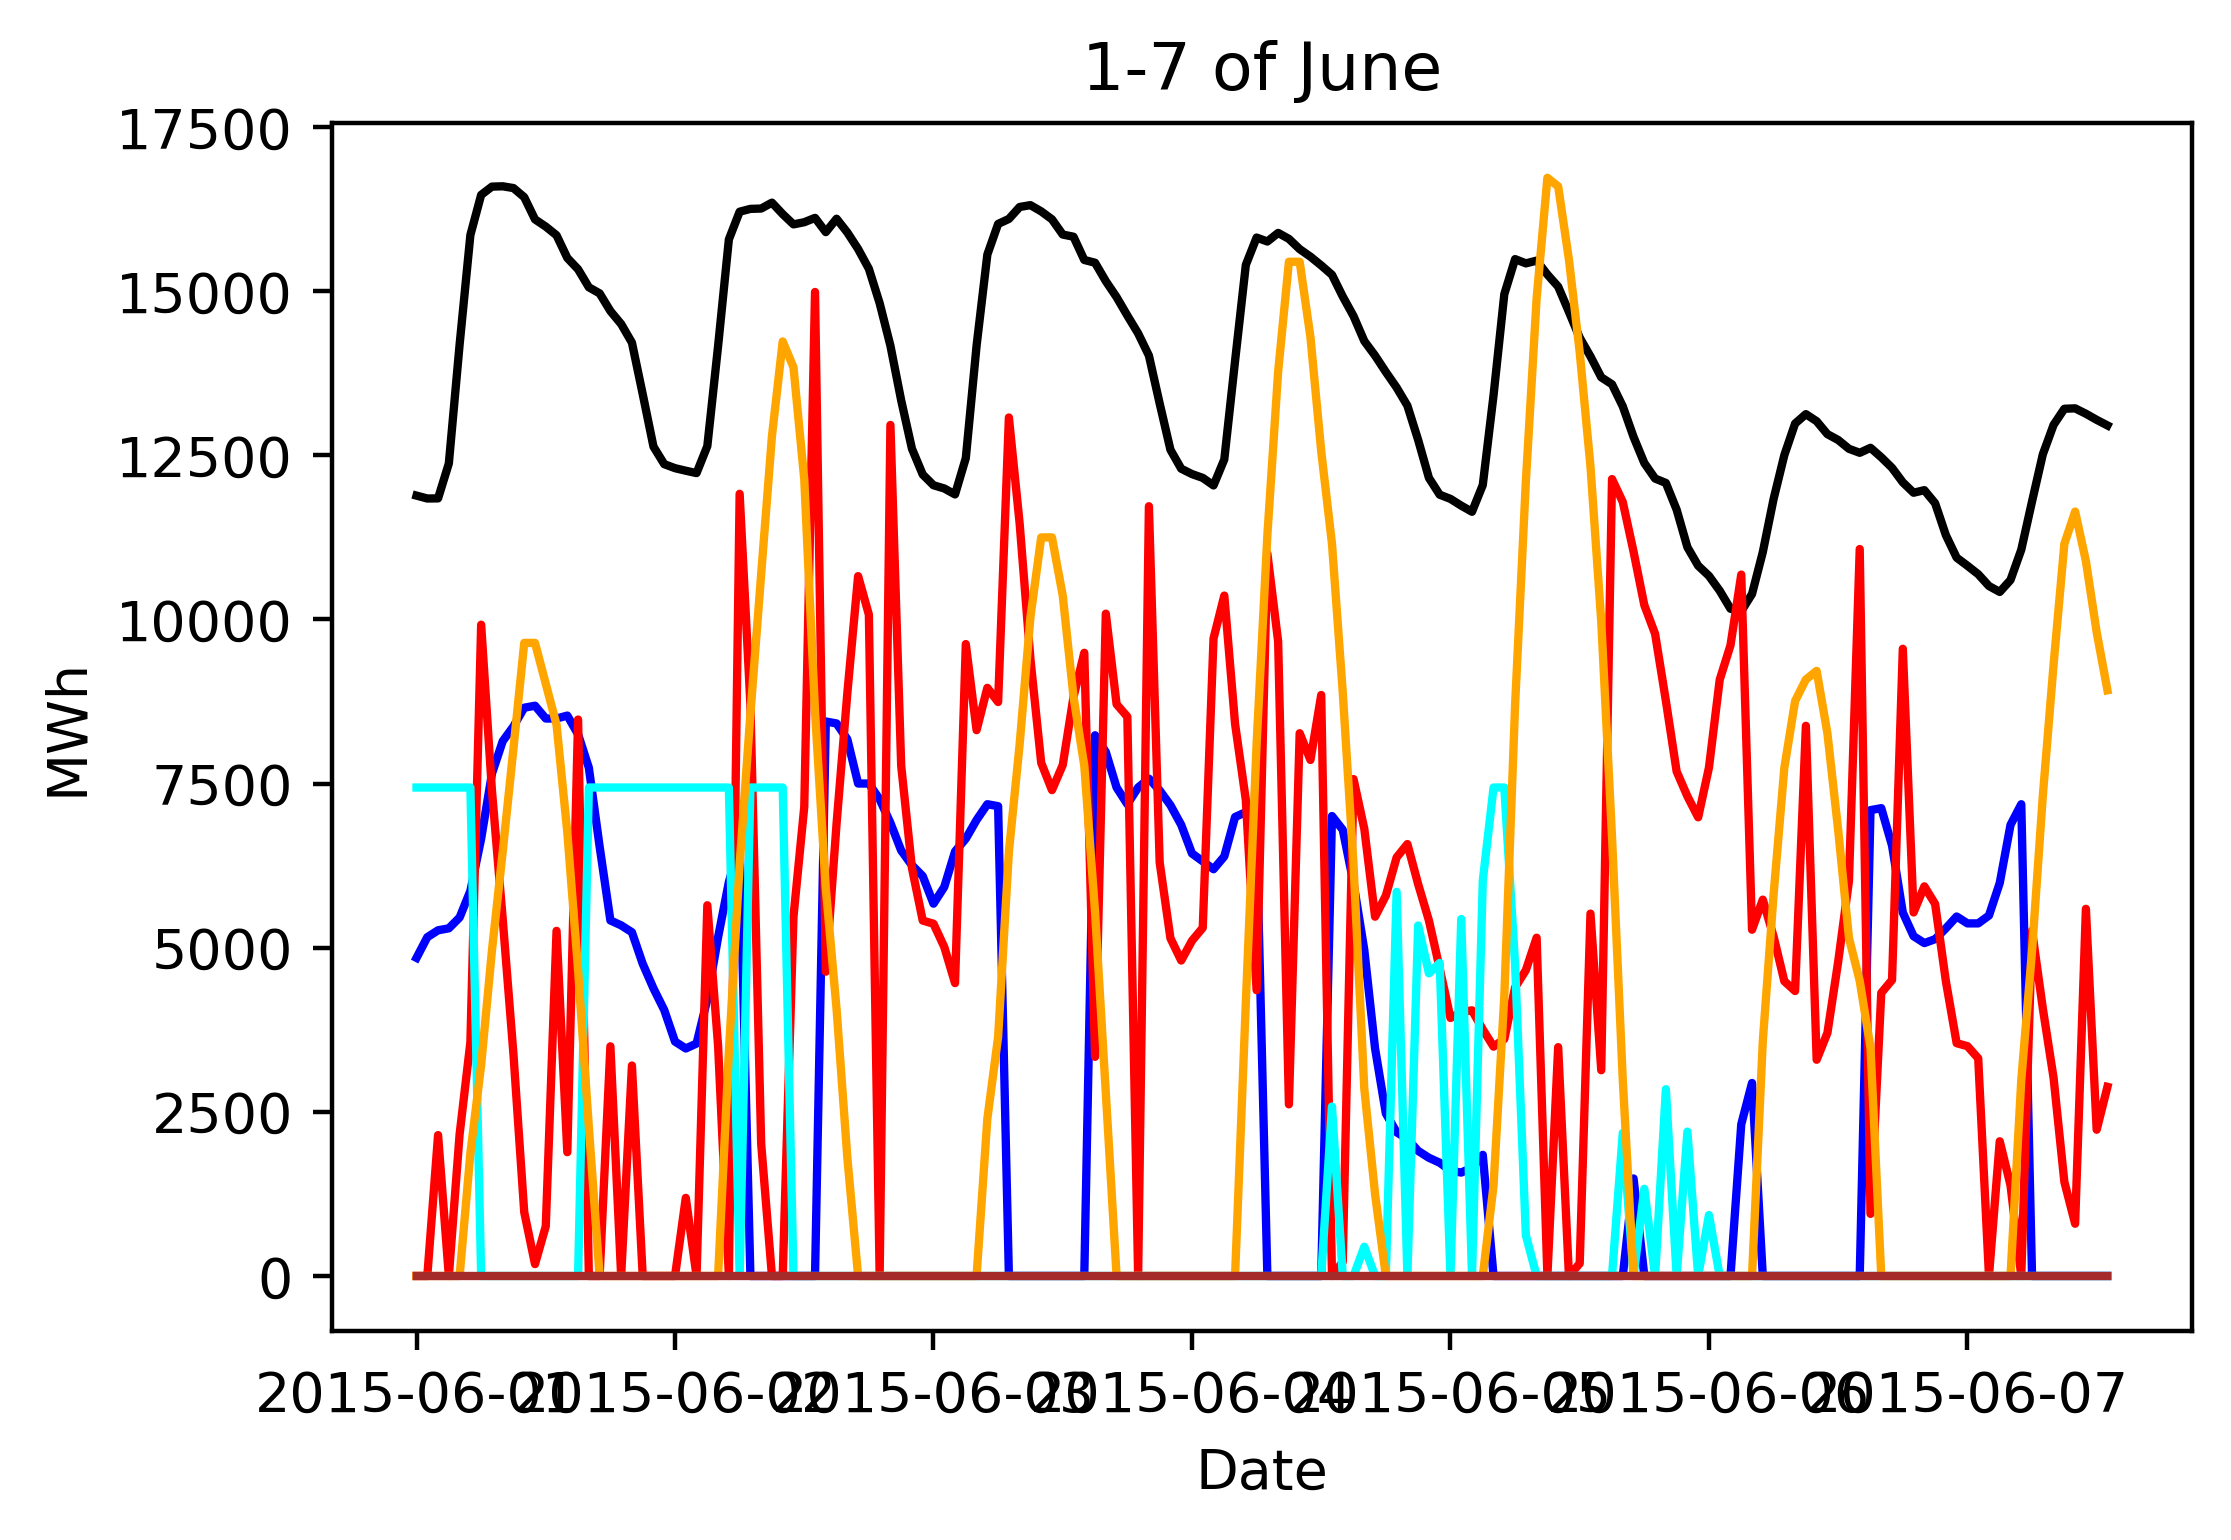

In [158]:
plt.figure(dpi=400)
plt.plot(network.loads_t.p['load'][l_range:u_range], color='black', label='elec demand')
plt.plot(network.generators_t.p['onshorewind'][l_range:u_range], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['offshorewind'][l_range:u_range], color='red', label='offshore wind')
plt.plot(network.generators_t.p['hydro'][l_range:u_range], color='cyan', label='hydro')
plt.plot(network.generators_t.p['solar'][l_range:u_range], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][l_range:u_range], color='brown', label='gas (OCGT)')
plt.ylabel('MWh')
plt.xlabel('Date')
plt.title('1-7 of June')
#plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

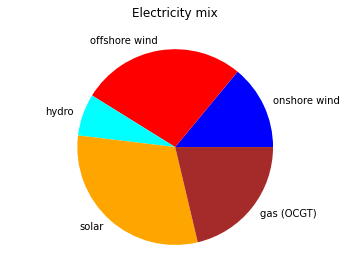

In [155]:
labels = ['onshore wind','offshore wind','hydro', 'solar', 'gas (OCGT)']
sizes = [network.generators.p_nom_opt['onshorewind'].sum(),
         network.generators.p_nom_opt['offshorewind'].sum(),
         network.generators.p_nom_opt['hydro'].sum(),
         network.generators.p_nom_opt['solar'].sum(),
         network.generators.p_nom_opt['OCGT'].sum()]

colors = ['blue','red','cyan', 'orange', 'brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [171]:
print(network.global_constraints.constant) #CO2 limit (constant in the constraint)

print(network.global_constraints.mu) #CO2 price (Lagrance multiplier in the constraint)

co2_limit    2910000.0
Name: constant, dtype: float64
co2_limit    2053.81168
Name: mu, dtype: float64


## PROJECT DESCRIPTION

Based on the previous example, you are asked to carry out the following tasks:

A. Choose a different country/region and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution from different technologies.

B. Investigate how sensitive is the optimum capacity mix to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer the emissions allowance to that historical data.

C. Investigate how sensitive are your results to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years.

D. Add some storage technology/ies and investigate how they behave and what is their impact on the optimal system configuration.

E. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.)

F. Select on target for decarbonizatio (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your result.

G. Connect your country with, at least, two neighbour countries. You can assume that the capacities in the neighbours are fixed or cooptimize the whole system. You can also include fixed interconnection capacities or cooptimize them with the generators capacities. Discuss your results.

H. Connect the electricity sector with another sector such as heating or transport, and cooptimize the two sectors. Discuss your results.

I. Finally, select one topic that is under discussion in your region. Design and implement some experiment to obtain relevant information regarding that topic. E.g.

[-] What are the consequences if Denmark decides not to install more onshore wind?

[-] Would it be more expensive if France decides to close its nuclear power plants?

[-] What will be the main impacts of the Viking link?

Write a short report (maximum 10 pages) including your main findings.

___
TIP: You can add a link with the following code.

The efficiency will be 1 if you are connecting two countries and different from one if, for example, you are connecting the electricity bus to the heating bus using a heat pump.
Setting p_min_pu=-1 makes the link reversible.


In [ ]:
network.add("Link",
             'country a - country b',
             bus0="electricity bus country a",
             bus1="electricity bus country b",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             length=600, # length (in km) between country a and country b
             capital_cost=400*600) # capital cost * length 